## Cleaning up Atlas data - IPSL CORDEX
**Function**      : Preprocess netCDF files and restructure the dataset<br>
**Author          : Team BETA**<br>
**First Built**   : 2021.10.15<br>
**Last Update     : 2021.10.15**<br>
**Library**       : os, numpy, netcdf4, xarray<br>
**Description**   : In this notebook serves to clean up Atlas data which is given in netcdf format and aggregate the data into a single file.<br>
**Return Values   : .nc files**<br>
**Note**          : All the data is saved to netCDF4 format. Note that CORDEX data has unstructured grid (curvilinear). It must be treated differently from IPSL REA data. And the batch processing script can not be applied. All the maps based on CORDEX will be generated using this notebook. <br>

In [9]:
import os
import numpy as np
import xarray as xr
from pathlib import Path
from netCDF4 import Dataset

import iris
import cartopy.crs as ccrs

import matplotlib.pyplot as plt

In [4]:
# please specify data path
datapath = '/mnt/d/NLeSC/BETA/EUCP/Atlas'
# please specify output path
output_path = '/mnt/d/NLeSC/BETA/EUCP/Atlas/preprocess'
os.makedirs(output_path, exist_ok = True)

# load mask info for cordex data
dataset_mask = Dataset(Path(datapath,'IPSL_REA',
                            'region_mask_NEU-CEU-MED_land.nc')) # xarray cannot work with lat lon with more than 1-dimension
mask = dataset_mask.variables['region_mask'][:]
# coordinate info for cordex data
mask_lat = dataset_mask.variables['lat'][:]
mask_lon = dataset_mask.variables['lon'][:]

### Pre-check the curvilinear grid and transform data to the target projection
Plot the mask using iris package, to handle the curvilinear grid.

In [5]:
# define the cube for the use of iris package
mask_lat_coord = iris.coords.AuxCoord(mask_lat,standard_name='latitude',units='degrees')
mask_lon_coord = iris.coords.AuxCoord(mask_lon,standard_name='longitude',units='degrees')
cube_mask = iris.cube.Cube(mask, long_name='IPSL CORDEX mask', var_name='mask',
                           units='1',aux_coords_and_dims=[(mask_lat_coord,(0,1)),(mask_lon_coord,(0,1))])
#print cube_ORAS4
# Transform cube to target projection
cube_mask_project, extent = iris.analysis.cartography.project(cube_mask, ccrs.PlateCarree(), nx=412, ny=424)




/home/yangliu/miniconda3/lib/python3.8/site-packages/iris/analysis/cartography.py:633: UserWarning: Coordinate system of latitude and longitude coordinates is not specified. Assuming WGS84 Geodetic.
  warnings.warn(


In [8]:
sample_data = Dataset(Path(datapath,'IPSL_REA',
                            'eur_CORDEX_pr_2041-2060_vs_1995-2014_10_DJF.nc'))
pr = sample_data['pr_weighted'][:]

/home/yangliu/miniconda3/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/yangliu/miniconda3/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:319: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/home/yangliu/miniconda3/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/home/yangliu/miniconda3/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn(

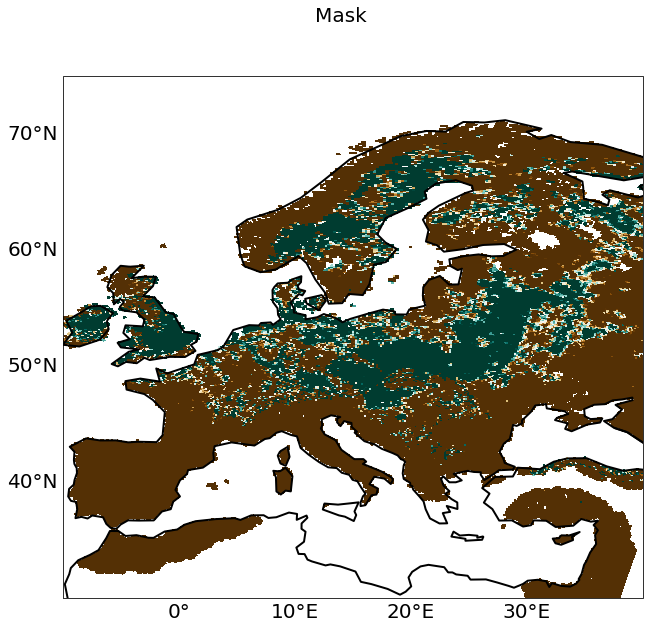

In [10]:
# mask data
pr_mask = np.ma.masked_where(mask == 0, pr)
# plot the map
fig1 = plt.figure(figsize=(12.8,9.6))
# suptitle is the title for the figure
fig1.suptitle('Mask', fontsize=20)
# Set up axes, which means different view of maps
ax = plt.axes(projection=ccrs.PlateCarree())
# Set limits of the map (choose area for plot)
ax.set_extent([-10,40,30,75],ccrs.PlateCarree()) # East, West, South, Nouth
ax.coastlines(resolution='110m', color='black', linewidth=2)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = True
gl.ylabels_left = True
gl.ylabels_right = False
gl.xlines = False
gl.ylines = False
gl.xlabel_style = {'size': 20, 'color': 'black'}
gl.ylabel_style = {'size': 20, 'color': 'black'}
cs = plt.pcolormesh(mask_lon, mask_lat, pr, cmap="BrBG", vmin=0, vmax=1)
plt.show()